## Elimination segmentation
> Inference client

In [1]:
#| default_exp segmentation
#| export
import dataclasses
import os
import pathlib
import time

from typing import Any, List, Optional, Tuple

import numpy as np
import torch
import numpy.typing as nptypes

import mlflow
import mmcv
from mmcv.transforms import Compose
from mmdet.utils import get_test_pipeline_cfg
from mmengine.config import Config, ConfigDict
from mmyolo.utils import register_all_modules
import tritonclient.http as httpclient

from csgo_clips_autotrim.experiment_utils.utils import TimeSplitTracker

In [2]:
#| export
mlflow.set_tracking_uri('https://mlflow.tenzing.shkhr.ovh')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'

def get_model_config(run_id: str) -> os.PathLike:
    """Get model config from mlflow's model store.

    Args:
        run_id (str)

    Returns:
        os.PathLike: Local path to model config.
    """
    return mlflow.artifacts.download_artifacts(artifact_uri=f'runs:/{run_id}/model_config.py')

In [3]:
#| export
register_all_modules()

def preprocess_image(image_path: os.PathLike, model_run_id: str) -> Tuple[nptypes.ArrayLike, Any, Any, Any]:
    tt = TimeSplitTracker()
    tt.add('start')
    model_config_path = get_model_config(model_run_id)
    tt.add('get model config')

    # Load evaluation pipeline.
    cfg = Config.fromfile(model_config_path)
    test_pipeline = get_test_pipeline_cfg(cfg)
    test_pipeline[0] = ConfigDict({'type': 'mmdet.LoadImageFromNDArray'})
    test_pipeline = Compose(test_pipeline)
    tt.add('load test pipeline')

    # Load image.
    bgr = mmcv.imread(image_path)
    rgb = mmcv.imconvert(bgr, 'bgr', 'rgb')
    data, samples = test_pipeline(dict(img=rgb, img_id=0)).values()
    tt.add('load image')

    # Get padding/scaling factors for resizing the image.
    pad_param = samples.get('pad_param', np.array([0, 0, 0, 0], dtype=np.float32))
    pad_param = torch.asarray([pad_param[2], pad_param[0], pad_param[2], pad_param[0]])
    scale_factor = samples.get('scale_factor', [1., 1])
    scale_factor = torch.asarray(scale_factor * 2)
    tt.add('get pad/scale')

    # Reshape and convert to float.
    data = data[np.newaxis, :]
    img = data.numpy()
    img = img.astype(np.float32)
    img /= 255.0
    tt.add('reshape and convert dtype')

    img_shape = samples.get('ori_shape', rgb.shape[:2])

    tt.show_summary()

    return img, pad_param, scale_factor, img_shape

In [4]:
#| export

@dataclasses.dataclass
class BBox:
    """Bounding box representation for image segment.
    NOTE: Bbox dimensions are in [xmin, ymin, xmax, ymax] format.
    """
    dims: List[int]

@dataclasses.dataclass
class EliminationEvent: 
    """Dataclass representing an elimination event.
    """
    event: Tuple[BBox, Optional[str]]
    eliminator: Optional[Tuple[BBox, Optional[str]]] = None
    weapon: Optional[Tuple[BBox, Optional[str]]] = None
    eliminated: Optional[Tuple[BBox, Optional[str]]] = None


@dataclasses.dataclass
class InferenceConfig:
    mlflow_artifact_run_id: str
    triton_model_name: str
    triton_url: str
    score_threshold: float

In [5]:
#| export
def segment_elimination_events(image_path: str, inference_config: InferenceConfig) -> List[EliminationEvent]:
    tt = TimeSplitTracker()

    tt.add('start')
    client = httpclient.InferenceServerClient(url=inference_config.triton_url)
    tt.add('client creation')

    img, pad_params, scale_factor, img_shape = preprocess_image(image_path, inference_config.mlflow_artifact_run_id)
    tt.add('preprocess')

    inputs = httpclient.InferInput('input', img.shape, datatype='FP32')
    inputs.set_data_from_numpy(img, binary_data=True)
    tt.add('set data')

    output_bbox = httpclient.InferRequestedOutput('dets', binary_data=True)
    output_labels = httpclient.InferRequestedOutput('labels', binary_data=True)
    tt.add('create output')
    
    # Perform inference.
    results = client.infer(model_name=inference_config.triton_model_name, inputs=[inputs], outputs=[output_bbox, output_labels])
    tt.add('inference')

    inference_output = results.as_numpy('dets')

    bboxes = inference_output[:, :, :-1]
    scores = inference_output[:, :, -1]
    bboxes -= pad_params.numpy()
    bboxes /= scale_factor.numpy()

    h, w = img_shape
    num_batches = bboxes.shape[0]

    detected_events = []

    for batch in range(num_batches):
        for bbox, score in zip(bboxes[batch], scores[batch]):
            if score < inference_config.score_threshold:
                continue

            detected_events.append(EliminationEvent(
                event=(BBox(list(bbox)), None)
            ))
    tt.add('transform results')

    tt.show_summary()

    return detected_events

In [6]:
SAMPLE_IMAGE_PATH = pathlib.Path('../data/difficult_test.png')
assert SAMPLE_IMAGE_PATH.exists(), "Sample image does not exist"

SAMPLE_MODEL_RUN_ID = '254e228656e348078b8663502a68065a'
CONFIG_FILE_NAME = 'yolov8_s_fast_1xb12-40e_csgo.py'

SAMPLE_MODEL_CONFIG_PATH = get_model_config(SAMPLE_MODEL_RUN_ID)


[INFO] 2023-07-23 16:02:45,055 botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials


In [8]:
%%time
events = segment_elimination_events(SAMPLE_IMAGE_PATH,
    InferenceConfig(
        mlflow_artifact_run_id=SAMPLE_MODEL_RUN_ID,
        triton_model_name='csgo-elimination-segmentation-yolov8',
        triton_url='localhost:8000',
        score_threshold=0.5))
events

CPU times: user 151 ms, sys: 17.7 ms, total: 169 ms
Wall time: 324 ms


[EliminationEvent(event=(BBox(dims=[1034.5565, 51.175957, 1277.2362, 79.37999]), None), eliminator=None, weapon=None, eliminated=None),
 EliminationEvent(event=(BBox(dims=[1018.4199, 78.74056, 1277.1625, 106.79359]), None), eliminator=None, weapon=None, eliminated=None)]

In [9]:
import matplotlib.pyplot as plt

from csgo_clips_autotrim.segmentation import show_mask, box_to_mask


def show_events(image_path: os.PathLike, elimination_eents: List[EliminationEvent]):
    bgr = mmcv.imread(image_path)
    rgb = mmcv.imconvert(bgr, 'bgr', 'rgb')

    plt.imshow(rgb)

    h, w =rgb.shape[:2]

    for event in elimination_eents:
        bbox, text = event.event
        print(bbox, text)
        show_mask(box_to_mask(bbox.dims, h, w), plt.gca())

BBox(dims=[1034.5565, 51.175957, 1277.2362, 79.37999]) None
BBox(dims=[1018.4199, 78.74056, 1277.1625, 106.79359]) None


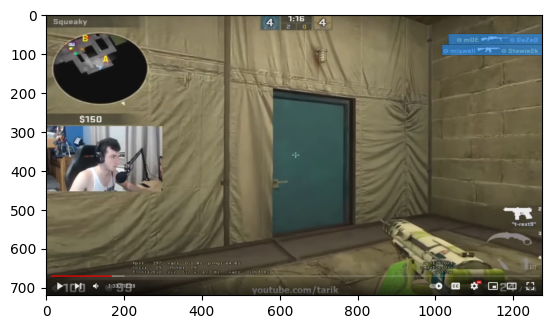

In [10]:
show_events(SAMPLE_IMAGE_PATH, events)